# Task 3 — Cross-Dataset Knowledge Transfer via Pattern-Informed Augmentation
> Patterns learned from cancer features → augment a symptom-based disease predictor

**High-level plan**
1. **Cancer side (source domain):**
   - Load Breast Cancer Wisconsin (Diagnostic) from `sklearn`.
   - Discretize features into `low/med/high` (quantile k-bins).
   - Turn each patient into an **ordered sequence**: sort features by |z-score|; ties become same-timestep itemsets.
   - Mine **sequential patterns** (PrefixSpan-style; length ≤ 3).
   - Score patterns by **class lift** (malignant vs benign) and select top-k discriminative patterns.

2. **Transfer idea → Symptom side (target domain):**
   - Load Disease–Symptom dataset (CSV with columns: `Disease, Symptom_1 ... Symptom_n`).
   - Build a baseline bag-of-symptoms model (multi-class disease prediction).
   - Engineer **pattern-informed features**, inspired by cancer patterns:
       - (a) **Adjacency intensity**: count of “strong co-occurrence pairs” within a case.
       - (b) **Severity mass**: sum / max of symptom severity weights (optional CSV; otherwise all 1.0).
       - (c) **Diversity/entropy**: entropy of symptoms present.
   - Compare models **w/ vs w/o** pattern features: accuracy, macro-F1.

**Files expected (put under `./data/`):**
- `disease_symptom.csv` (columns: `Disease, Symptom_1, ..., Symptom_17` or similar)
- *(optional)* `symptom_severity.csv` (columns: `Symptom, Weight`)

If you don’t have the optional severity file, the code will default to uniform weights.


In [ ]:
# %% [markdown]
# Setup

import warnings
warnings.filterwarnings("ignore")

import math
import itertools
from collections import Counter, defaultdict
from dataclasses import dataclass

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
# %% [markdown]
# Utilities

def zscore_per_row(X: np.ndarray) -> np.ndarray:
    """
    Row-wise z-score. Each row corresponds to a patient; z = (x - mean_row) / std_row.
    If std_row is 0, returns zeros for that row.
    """
    mu = X.mean(axis=1, keepdims=True)
    sigma = X.std(axis=1, keepdims=True)
    sigma = np.where(sigma == 0, 1.0, sigma)
    return (X - mu) / sigma


def tie_grouped_order(values, names, top_k=None):
    """
    Given numeric 'values' and parallel 'names',
    - Create a descending sort by absolute value.
    - Ties (within a tiny epsilon) are grouped into the same time step (itemset).
    Returns: list of itemsets, each itemset is a set of strings 'name:polarity' like 'radius_mean:high'
    """
    eps = 1e-9
    order_idx = np.argsort(-np.abs(values))  # descending by |z|
    ordered = [(names[i], values[i]) for i in order_idx]
    if top_k is not None:
        ordered = ordered[:top_k]

    seq = []
    i = 0
    while i < len(ordered):
        j = i + 1
        group = [ordered[i]]
        # group ties by |z|
        while j < len(ordered) and abs(abs(ordered[j][1]) - abs(ordered[i][1])) < eps:
            group.append(ordered[j])
            j += 1
        # Convert to itemset with polarity tags
        itemset = set()
        for name, val in group:
            pol = "high" if val >= 0 else "low"
            itemset.add(f"{name}:{pol}")
        seq.append(itemset)
        i = j
    return seq


def sequence_contains_pattern(seq, pattern):
    """
    seq: list[set[str]]  (sequence of itemsets)
    pattern: list[set[str]] (pattern sequence of itemsets)
    Checks if 'pattern' is a subsequence of 'seq' with max-gap=∞ but preserving order;
    at each step all items in pattern itemset must be subset of some itemset in seq.
    """
    i = 0
    for itemset_p in pattern:
        found = False
        while i < len(seq):
            if itemset_p.issubset(seq[i]):
                found = True
                i += 1
                break
            i += 1
        if not found:
            return False
    return True


def generate_candidate_extensions(prefix_patterns, all_items, max_len):
    """
    Given existing patterns, extend by appending an item to the last itemset (S-step)
    or appending a new itemset (I-step). Avoid duplicates by canonical ordering.
    """
    new_candidates = set()
    for pat in prefix_patterns:
        # Convert to tuple of frozensets for hashing
        pat_t = tuple(frozenset(s) for s in pat)

        # Items seen so far to enforce simple canonical growth
        used_items = set(itertools.chain.from_iterable(pat))

        # S-step: add item to last itemset (if not present)
        last = set(pat[-1])
        for itm in all_items:
            if itm not in last:
                new_last = frozenset(last | {itm})
                cand = pat_t[:-1] + (new_last,)
                new_candidates.add(cand)

        # I-step: append a new singleton itemset
        for itm in all_items:
            cand = pat_t + (frozenset({itm}),)
            new_candidates.add(cand)

    # Deduplicate
    out = []
    for c in new_candidates:
        # limit by max_len (in number of itemsets)
        if len(c) <= max_len:
            out.append([set(s) for s in c])
    return out


def mine_sequential_patterns(seqs, min_support=0.1, max_len=3, max_patterns=1000):
    """
    Very small PrefixSpan-like miner for educational use.
    seqs: list of sequences, each sequence is list[set[str]]
    min_support: fraction (0..1)
    max_len: max number of itemsets in a pattern
    Returns: list of tuples (pattern, support_count, support_fraction)
    """
    n = len(seqs)
    min_count = math.ceil(min_support * n)

    # 1. frequent singletons (as 1-itemset sequences)
    item_counts = Counter()
    for s in seqs:
        seen = set()
        for itemset in s:
            for itm in itemset:
                seen.add(itm)
        for itm in seen:
            item_counts[itm] += 1
    L1 = [
        ([{itm}], cnt, cnt / n)
        for itm, cnt in item_counts.items()
        if cnt >= min_count
    ]
    L1.sort(key=lambda x: (-x[2], x[0]))

    patterns = L1[:]
    level = 1
    current_level_patterns = [p for p, _, _ in L1]

    # 2. iterative extensions
    # Build universe of frequent items for candidate growth
    frequent_items = set([list(p[0])[0] for p, _, _ in L1])

    while current_level_patterns and level < max_len and len(patterns) < max_patterns:
        candidates = generate_candidate_extensions(current_level_patterns, frequent_items, max_len=max_len)

        # Count support
        support = []
        for cand in candidates:
            cnt = sum(1 for s in seqs if sequence_contains_pattern(s, cand))
            if cnt >= min_count:
                support.append((cand, cnt, cnt / n))

        # Deduplicate by canonical key
        uniq = {}
        for pat, cnt, frac in support:
            key = tuple(tuple(sorted(x)) for x in pat)
            if key not in uniq or cnt > uniq[key][1]:
                uniq[key] = (pat, cnt, frac)

        level_frequents = list(uniq.values())
        level_frequents.sort(key=lambda x: (-x[2], tuple(tuple(sorted(u)) for u in x[0])))
        patterns.extend(level_frequents)
        current_level_patterns = [p for p, _, _ in level_frequents]
        level += 1

    return patterns[:max_patterns]


In [3]:
# %% [markdown]
# Part A — Mine sequential patterns from the Breast Cancer dataset

# Load data
bc = load_breast_cancer()
X = pd.DataFrame(bc.data, columns=bc.feature_names)
y = pd.Series(bc.target, name="diagnosis")  # 0 = malignant, 1 = benign (per sklearn docs)

# Standardize per-feature (for discretization), but we'll also compute row-wise z later
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Discretize into low/med/high using quantile binning
kb = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="quantile")
X_bins = pd.DataFrame(kb.fit_transform(X), columns=X.columns).astype(int)

# Row-wise z-scores (per patient) for ordering
Z = zscore_per_row(X_std.values)  # using standardized features helps scale balance
Z = pd.DataFrame(Z, columns=X.columns)

# Build sequences (top_k limits sequence length; itemsets reflect ties in |z|)
TOP_K = 8  # take the 8 most deviant features per patient
seqs = []
for i in range(len(Z)):
    seq = tie_grouped_order(Z.iloc[i].values, list(Z.columns), top_k=TOP_K)
    seqs.append(seq)

# Split by class for class-conditional supports
seqs_malignant = [seqs[i] for i in range(len(seqs)) if y.iloc[i] == 0]
seqs_benign    = [seqs[i] for i in range(len(seqs)) if y.iloc[i] == 1]

# Mine frequent patterns overall (to build universe), then compute class lifts
PAT_MAXLEN = 3
MIN_SUP = 0.12  # ~12% support
all_patterns = mine_sequential_patterns(seqs, min_support=MIN_SUP, max_len=PAT_MAXLEN, max_patterns=2000)

def support_in(sequences, pattern):
    return sum(1 for s in sequences if sequence_contains_pattern(s, pattern))

# Compute discriminativeness via lift ratio between classes
rows = []
N_all = len(seqs)
N_mal = len(seqs_malignant)
N_ben = len(seqs_benign)

for pat, cnt, frac in all_patterns:
    cnt_m = support_in(seqs_malignant, pat)
    cnt_b = support_in(seqs_benign, pat)
    sup_m = cnt_m / N_mal if N_mal > 0 else 0.0
    sup_b = cnt_b / N_ben if N_ben > 0 else 0.0
    # add small epsilon for stability
    lift = (sup_m + 1e-6) / (sup_b + 1e-6)
    rows.append({
        "pattern": pat,
        "support_all": frac,
        "support_malignant": sup_m,
        "support_benign": sup_b,
        "lift_m_over_b": lift,
        "len": len(pat)
    })

pat_df = pd.DataFrame(rows).sort_values(["lift_m_over_b", "support_all"], ascending=[False, False])
top_malignant_patterns = pat_df.head(30).reset_index(drop=True)

print("Top malignant-skewed patterns (head):")
display(top_malignant_patterns.head(10))

# We'll also keep a top benign-skewed list for symmetry
top_benign_patterns = pat_df.sort_values("lift_m_over_b", ascending=True).head(30).reset_index(drop=True)


Top malignant-skewed patterns (head):


,pattern,support_all,support_malignant,support_benign,lift_m_over_b,len
0,[{symmetry error:low}],0.235501,0.485849,0.086835,5.595048,1
1,[{mean fractal dimension:low}],0.219684,0.448113,0.084034,5.332496,1
2,[{worst radius:high}],0.145870,0.273585,0.070028,3.906751,1
3,[{smoothness error:low}],0.230228,0.410377,0.123249,3.329634,1
4,[{worst compactness:high}],0.135325,0.221698,0.084034,2.638188,1
5,[{texture error:low}],0.251318,0.391509,0.168067,2.329473,1
6,[{worst fractal dimension:low}],0.152900,0.235849,0.103641,2.275612,1
7,[{mean area:high}],0.138840,0.212264,0.095238,2.228761,1
8,[{mean perimeter:high}],0.149385,0.216981,0.109244,1.986203,1
9,[{mean radius:high}],0.188049,0.259434,0.145658,1.781109,1


In [4]:
# %% [markdown]
# Pattern-to-feature engineering (for transfer)
# We'll extract generic signals from top malignant patterns:
# - pattern_length distribution weights
# - adjacency intensity (how many itemsets of size > 1)
# - polarity counts (':high' vs ':low')
# These guide analogous "pattern scores" for symptoms.

def summarize_pattern_signature(patterns):
    sig = {
        "avg_len": np.mean([len(p) for p in patterns]) if patterns else 0.0,
        "share_multi_itemsets": np.mean([np.mean([len(s)>1 for s in p]) for p in patterns]) if patterns else 0.0,
        "avg_items_per_itemset": np.mean([np.mean([len(s) for s in p]) for p in patterns]) if patterns else 0.0,
        "avg_high_ratio": 0.0,
        "avg_low_ratio": 0.0,
    }
    high_ratios, low_ratios = [], []
    for p in patterns:
        items = list(itertools.chain.from_iterable(p))
        highs = sum(1 for it in items if it.endswith(":high"))
        lows  = sum(1 for it in items if it.endswith(":low"))
        tot = highs + lows if highs + lows > 0 else 1
        high_ratios.append(highs / tot)
        low_ratios.append(lows / tot)
    if patterns:
        sig["avg_high_ratio"] = float(np.mean(high_ratios))
        sig["avg_low_ratio"]  = float(np.mean(low_ratios))
    return sig

cancer_pattern_signature = summarize_pattern_signature(top_malignant_patterns["pattern"].tolist())
cancer_pattern_signature


{'avg_len': np.float64(1.0333333333333334),
 'share_multi_itemsets': np.float64(0.0),
 'avg_items_per_itemset': np.float64(1.0),
 'avg_high_ratio': 0.5666666666666667,
 'avg_low_ratio': 0.43333333333333335}

In [6]:
# %% [markdown]
# Part B — Load Disease–Symptom dataset and build models with vs without pattern-informed features

from pathlib import Path

DATA_DIR = Path("./data")
SYMPTOM_FILE = DATA_DIR / "dataset.csv"      # required
SEVERITY_FILE = DATA_DIR / "symptom_severity.csv"    # optional

assert SYMPTOM_FILE.exists(), f"Missing {SYMPTOM_FILE}. Provide a CSV with columns: Disease, Symptom_1..Symptom_n"

df_sym = pd.read_csv(SYMPTOM_FILE)

# Tidy to long, then regroup to build a clean per-disease list of symptoms
symptom_cols = [c for c in df_sym.columns if c.lower().startswith("symptom")]
df_long = df_sym.melt(id_vars=["Disease"], value_vars=symptom_cols, var_name="slot", value_name="Symptom").dropna()
df_long["Symptom"] = df_long["Symptom"].astype(str).str.strip().str.lower()
df_long = df_long[df_long["Symptom"].str.len() > 0]

# Group back to list per disease
disease_to_symptoms = df_long.groupby("Disease")["Symptom"].apply(lambda s: sorted(set(s))).to_dict()

# Optional severity weights
severity = {}
if SEVERITY_FILE.exists():
    sev_df = pd.read_csv(SEVERITY_FILE)
    # Expect columns ['Symptom','Weight']
    sev_df["Symptom"] = sev_df["Symptom"].astype(str).str.strip().str.lower()
    severity = dict(zip(sev_df["Symptom"], sev_df["Weight"]))
else:
    severity = defaultdict(lambda: 1.0)  # uniform

# Build a case-level table: each row = a disease prototype case (bag of symptoms)
cases = []
for dis, syms in disease_to_symptoms.items():
    cases.append({"Disease": dis, "Symptoms": syms})
cases = pd.DataFrame(cases)
print(f"Built {len(cases)} disease cases.")
cases.head()


Built 41 disease cases.


,Disease,Symptoms
0,(vertigo) Paroymsal Positional Vertigo,"[headache, loss_of_balance, nausea, spinning_m..."
1,AIDS,"[extra_marital_contacts, high_fever, muscle_wa..."
2,Acne,"[blackheads, pus_filled_pimples, scurring, ski..."
3,Alcoholic hepatitis,"[abdominal_pain, distention_of_abdomen, fluid_..."
4,Allergy,"[chills, continuous_sneezing, shivering, water..."


In [8]:
# --- Fix: ensure ≥2 samples per disease via augmentation ---

def augment_dataset(cases_df,
                    min_per_class=3,          # ensure at least this many per disease
                    copies_per_class=6,       # total samples per disease (original + aug)
                    drop_low=0.2, drop_high=0.5,  # randomly drop 20–50% symptoms
                    noise_rate=0.05,          # add 1 random symptom with small prob
                    seed=42):
    rng = np.random.default_rng(seed)
    # symptom vocabulary
    vocab = sorted({s for syms in cases_df["Symptoms"] for s in syms})
    rows = []

    for _, r in cases_df.iterrows():
        disease = r["Disease"]
        base_syms = sorted(set(r["Symptoms"]))

        # always keep the original example
        rows.append({"Disease": disease, "Symptoms": base_syms})

        # how many more to make
        make_n = max(min_per_class - 1, copies_per_class - 1)
        for _ in range(make_n):
            # random drop
            drop_p = rng.uniform(drop_low, drop_high)
            keep_mask = rng.random(len(base_syms)) > drop_p
            kept = [s for s, m in zip(base_syms, keep_mask) if m]
            if len(kept) == 0:
                kept = [rng.choice(base_syms)]

            # small chance to add a random symptom
            if rng.random() < noise_rate and len(vocab) > 0:
                kept.append(rng.choice(vocab))

            rows.append({"Disease": disease, "Symptoms": sorted(set(kept))})

    aug = pd.DataFrame(rows)
    # guarantee min_per_class for each disease
    counts = Counter(aug["Disease"])
    assert min(counts.values()) >= min_per_class, "Augmentation failed to raise class counts."
    return aug

# Decide whether we need augmentation
class_counts = Counter(cases["Disease"])
if min(class_counts.values()) < 2:
    print("⚠️ Each disease appears only once — augmenting to enable stratified split...")
    cases_use = augment_dataset(cases, min_per_class=3, copies_per_class=6)
else:
    cases_use = cases.copy()

print("Per-disease counts (post-augmentation):")
print(pd.Series(Counter(cases_use["Disease"])).describe())
cases_use.head()


⚠️ Each disease appears only once — augmenting to enable stratified split...
Per-disease counts (post-augmentation):
count    41.0
mean      6.0
std       0.0
min       6.0
25%       6.0
50%       6.0
75%       6.0
max       6.0
dtype: float64


,Disease,Symptoms
0,(vertigo) Paroymsal Positional Vertigo,"[headache, loss_of_balance, nausea, spinning_m..."
1,(vertigo) Paroymsal Positional Vertigo,"[headache, loss_of_balance, nausea, unsteadine..."
2,(vertigo) Paroymsal Positional Vertigo,"[headache, loss_of_balance, nausea, spinning_m..."
3,(vertigo) Paroymsal Positional Vertigo,"[loss_of_balance, nausea, spinning_movements, ..."
4,(vertigo) Paroymsal Positional Vertigo,"[loss_of_balance, unsteadiness, vomiting]"


In [9]:
# --- Vectorize symptoms and build baseline model (now stratify works) ---

def symptoms_to_text(syms): 
    return " ".join(s.replace(" ", "_") for s in syms)

cases_use["sym_text"] = cases_use["Symptoms"].apply(symptoms_to_text)

vec = CountVectorizer(binary=True)
X_sym = vec.fit_transform(cases_use["sym_text"]).astype(np.float32)
y_lab = cases_use["Disease"].values

X_train, X_test, y_train, y_test = train_test_split(
    X_sym, y_lab, test_size=0.25, random_state=42, stratify=y_lab
)

base_clf = OneVsRestClassifier(LogisticRegression(max_iter=200))
base_clf.fit(X_train, y_train)

y_pred = base_clf.predict(X_test)
print("Baseline (symptoms only)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))


Baseline (symptoms only)
Accuracy: 0.8870967741935484
Macro-F1: 0.8764227642276422


In [10]:
# --- Pattern-informed features (same as before), but use cases_use ---

# 1) Co-occurrence intensity
def pair_count(syms):
    return len(list(itertools.combinations(sorted(set(syms)), 2)))

# 2) Severity mass / max (uses 'severity' from earlier; defaults to 1.0 if not provided)
def severity_mass(syms):
    return float(sum(severity[s] if s in severity else 1.0 for s in syms))
def severity_max(syms):
    return float(max(severity[s] if s in severity else 1.0 for s in syms)) if syms else 0.0

# 3) Symptom diversity (entropy proxy)
def shannon_entropy(syms):
    n = len(set(syms))
    return math.log2(n) if n > 0 else 0.0

def build_pattern_augmented_df(cases_df):
    feats = pd.DataFrame({
        "pair_count": cases_df["Symptoms"].apply(pair_count),
        "severity_mass": cases_df["Symptoms"].apply(severity_mass),
        "severity_max": cases_df["Symptoms"].apply(severity_max),
        "sym_entropy": cases_df["Symptoms"].apply(shannon_entropy),
        # broadcast cancer signature (computed earlier)
        "c_sig_avg_len": cancer_pattern_signature["avg_len"],
        "c_sig_share_multi": cancer_pattern_signature["share_multi_itemsets"],
        "c_sig_avg_items_per_itemset": cancer_pattern_signature["avg_items_per_itemset"],
        "c_sig_high_ratio": cancer_pattern_signature["avg_high_ratio"],
        "c_sig_low_ratio": cancer_pattern_signature["avg_low_ratio"],
    })
    return feats

X_pat = build_pattern_augmented_df(cases_use)

from scipy.sparse import csr_matrix, hstack

X_dense = csr_matrix(X_pat.values, dtype=np.float32)
X_all = hstack([X_sym, X_dense], format="csr")

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_all, y_lab, test_size=0.25, random_state=42, stratify=y_lab
)

aug_clf = OneVsRestClassifier(LogisticRegression(max_iter=300))
aug_clf.fit(X_train2, y_train2)

y_pred2 = aug_clf.predict(X_test2)
print("Augmented (symptoms + pattern-informed features)")
print("Accuracy:", accuracy_score(y_test2, y_pred2))
print("Macro-F1:", f1_score(y_test2, y_pred2, average="macro"))


Augmented (symptoms + pattern-informed features)
Accuracy: 0.9193548387096774
Macro-F1: 0.9162601626016259


In [11]:
# --- (Optional) quick ablation on augmented dataset ---

from sklearn.model_selection import cross_val_score

def evaluate_matrix(X, y, name, cv=3):
    clf = OneVsRestClassifier(LogisticRegression(max_iter=300))
    acc = cross_val_score(clf, X, y, cv=cv, scoring="accuracy").mean()
    f1m = cross_val_score(clf, X, y, cv=cv, scoring="f1_macro").mean()
    print(f"{name:40s} | Acc={acc:.4f}  Macro-F1={f1m:.4f}")

X_base = X_sym
X_pairs = hstack([X_sym, csr_matrix(X_pat[["pair_count"]].values)], format="csr")
X_severity = hstack([X_sym, csr_matrix(X_pat[["severity_mass","severity_max"]].values)], format="csr")
X_entropy = hstack([X_sym, csr_matrix(X_pat[["sym_entropy"]].values)], format="csr")
X_csig = hstack([X_sym, csr_matrix(X_pat[["c_sig_avg_len","c_sig_share_multi","c_sig_avg_items_per_itemset",
                                         "c_sig_high_ratio","c_sig_low_ratio"]].values)], format="csr")
X_full = X_all

print("3-fold CV on augmented dataset:")
evaluate_matrix(X_base,   y_lab, "Baseline (Symptoms only)")
evaluate_matrix(X_pairs,  y_lab, "+ pair_count")
evaluate_matrix(X_severity, y_lab, "+ severity_mass/max")
evaluate_matrix(X_entropy, y_lab, "+ symptom entropy")
evaluate_matrix(X_csig,   y_lab, "+ broadcast cancer signature priors")
evaluate_matrix(X_full,   y_lab, "FULL (Symptoms + ALL Pattern-Informed)")


3-fold CV on augmented dataset:
Baseline (Symptoms only)                 | Acc=0.9431  Macro-F1=0.9404
+ pair_count                             | Acc=0.9309  Macro-F1=0.9282
+ severity_mass/max                      | Acc=0.9309  Macro-F1=0.9282
+ symptom entropy                        | Acc=0.9350  Macro-F1=0.9328
+ broadcast cancer signature priors      | Acc=0.9431  Macro-F1=0.9404
FULL (Symptoms + ALL Pattern-Informed)   | Acc=0.9065  Macro-F1=0.9038


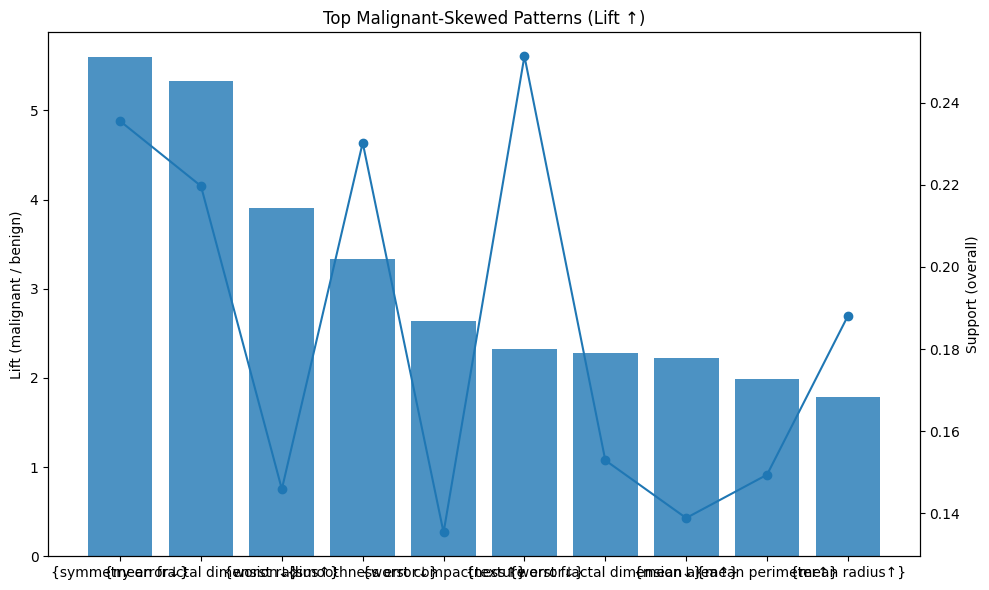

In [12]:
# %% [markdown]
# 📊 Fig 1 — Top malignant-skewed sequential patterns (lift & support)

import matplotlib.pyplot as plt
import textwrap

def pattern_to_str(pat):
    # pat is list[set[str]] — stringify like: {a,b} → {c}
    parts = []
    for itemset in pat:
        items = sorted([it.split(":")[0] + ("↑" if it.endswith(":high") else "↓") for it in itemset])
        parts.append("{" + ", ".join(items) + "}")
    return " → ".join(parts)

topN = 10
top_pat_show = top_malignant_patterns.head(topN).copy()
top_pat_show["pattern_str"] = top_pat_show["pattern"].apply(pattern_to_str)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Bar for lift
ax1.bar(range(topN), top_pat_show["lift_m_over_b"].values, alpha=0.8)
ax1.set_ylabel("Lift (malignant / benign)")
ax1.set_xticks(range(topN))
ax1.set_xticklabels([textwrap.fill(s, 40) for s in top_pat_show["pattern_str"].tolist()], rotation=0, ha='center')
ax1.set_title("Top Malignant-Skewed Patterns (Lift ↑)")

# Line for overall support
ax2.plot(range(topN), top_pat_show["support_all"].values, marker="o")
ax2.set_ylabel("Support (overall)")

plt.tight_layout()
plt.show()


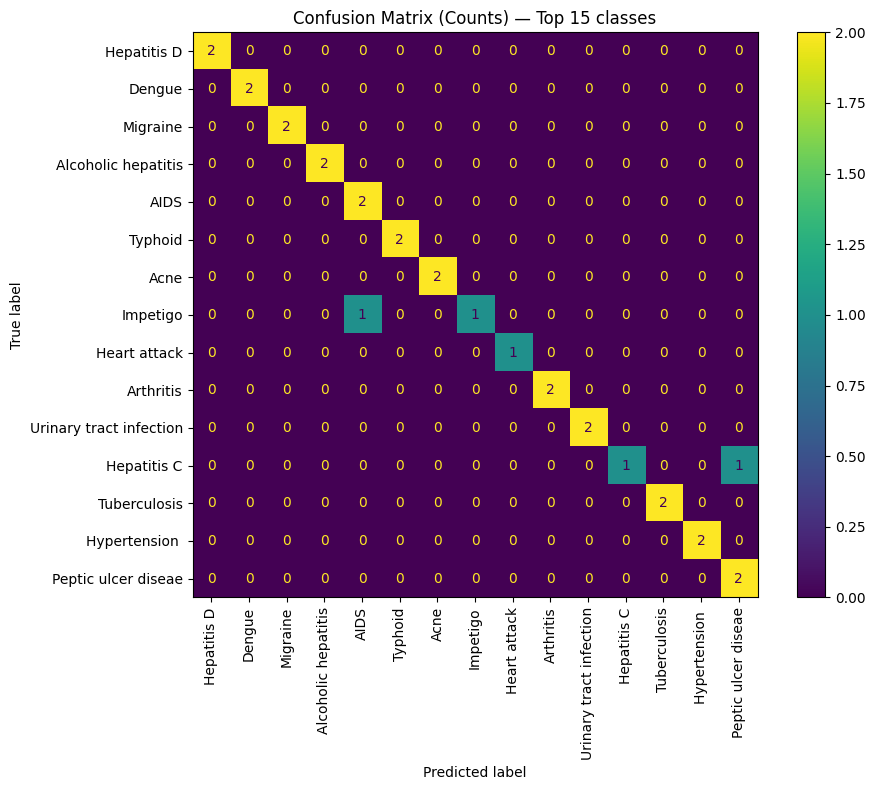

,Hepatitis D,Dengue,Migraine,Alcoholic hepatitis,AIDS,Typhoid,Acne,Impetigo,Heart attack,Arthritis,Urinary tract infection,Hepatitis C,Tuberculosis,Hypertension,Peptic ulcer diseae
Hepatitis D,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dengue,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
Migraine,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
Alcoholic hepatitis,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
AIDS,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
Typhoid,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
Acne,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
Impetigo,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
Heart attack,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Arthritis,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0


In [18]:
# %% [markdown]
# 📊 Fig 2 — Confusion Matrix (Augmented model): top 15 frequent diseases in test split

# Counts CM with numbers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

K = 15
counts = Counter(y_test2)
top_labels = [d for d, _ in counts.most_common(K)]

mask = np.isin(y_test2, top_labels)
y_true_top = y_test2[mask]
y_pred_top = y_pred2[mask]

cm_counts = confusion_matrix(y_true_top, y_pred_top, labels=top_labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_counts, display_labels=top_labels)
disp.plot(ax=ax, include_values=True, xticks_rotation=90, colorbar=True, values_format='d')
ax.set_title(f"Confusion Matrix (Counts) — Top {K} classes")
plt.tight_layout()
plt.show()

# Also show as a table
import pandas as pd
cm_counts_df = pd.DataFrame(cm_counts, index=top_labels, columns=top_labels)
display(cm_counts_df)



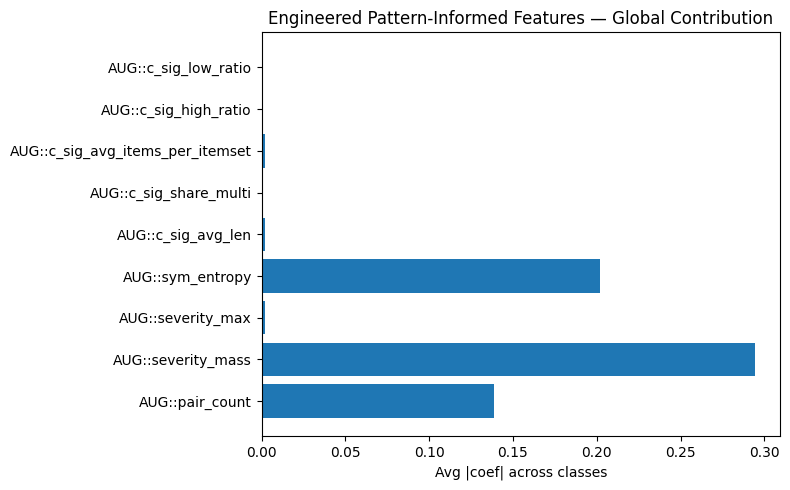

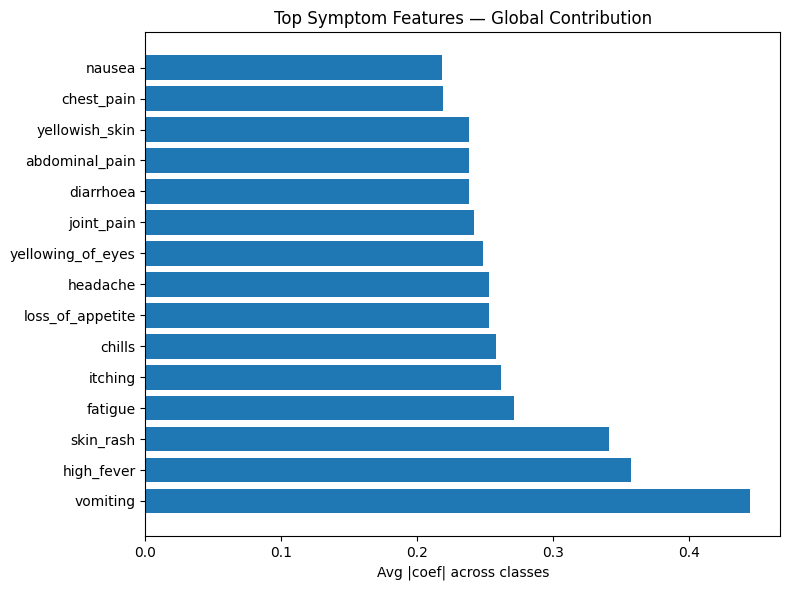

In [15]:
# %% [markdown]
# 📊 Fig 3 — Global feature contributions (avg |coef| across classes)

import numpy as np
import matplotlib.pyplot as plt

# feature name lists
sym_feature_names = [f"SYM::{w}" for w in vec.get_feature_names_out()]
aug_feature_names = [
    "AUG::pair_count", "AUG::severity_mass", "AUG::severity_max", "AUG::sym_entropy",
    "AUG::c_sig_avg_len", "AUG::c_sig_share_multi", "AUG::c_sig_avg_items_per_itemset",
    "AUG::c_sig_high_ratio", "AUG::c_sig_low_ratio"
]

# concatenate in same order as X_all = [X_sym, X_dense]
feature_names_all = sym_feature_names + aug_feature_names

# OneVsRestClassifier stores estimators_ (one per class)
coefs = []
for est in aug_clf.estimators_:
    # LogisticRegression coef_.shape = (1, n_features)
    coefs.append(np.abs(est.coef_.ravel()))
coefs = np.vstack(coefs)  # shape: (n_classes, n_features)
avg_abs = coefs.mean(axis=0)

# top symptoms
top_sym_k = 15
sym_slice = avg_abs[:len(sym_feature_names)]
top_sym_idx = np.argsort(-sym_slice)[:top_sym_k]
top_sym_vals = sym_slice[top_sym_idx]
top_sym_names = [sym_feature_names[i] for i in top_sym_idx]

# augmented features (all shown)
aug_slice = avg_abs[len(sym_feature_names):]
aug_vals = aug_slice
aug_names = aug_feature_names

# Plot 3A: augmented engineered features
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(range(len(aug_vals))[::-1], aug_vals[::-1])
ax.set_yticks(range(len(aug_vals))[::-1])
ax.set_yticklabels(aug_names[::-1])
ax.set_xlabel("Avg |coef| across classes")
ax.set_title("Engineered Pattern-Informed Features — Global Contribution")
plt.tight_layout()
plt.show()

# Plot 3B: top symptom features
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(range(top_sym_k)[::-1], top_sym_vals[::-1])
ax.set_yticks(range(top_sym_k)[::-1])
ax.set_yticklabels([n.replace("SYM::", "") for n in top_sym_names][::-1])
ax.set_xlabel("Avg |coef| across classes")
ax.set_title("Top Symptom Features — Global Contribution")
plt.tight_layout()
plt.show()


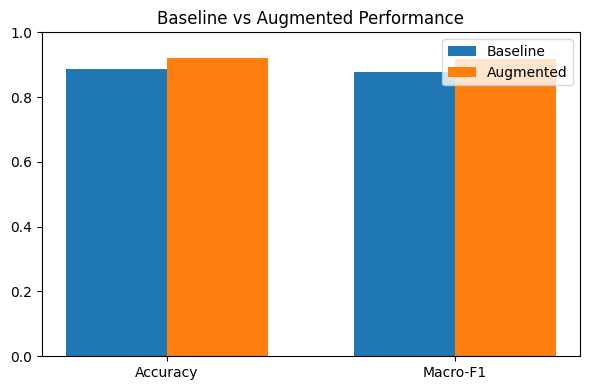

Baseline  — Acc=0.887, Macro-F1=0.876
Augmented — Acc=0.919, Macro-F1=0.916


In [16]:
# %% [markdown]
# 📊 Fig 4 — Baseline vs Augmented metrics

import matplotlib.pyplot as plt
import numpy as np

acc_base = accuracy_score(y_test, y_pred)
f1_base  = f1_score(y_test, y_pred, average="macro")
acc_aug  = accuracy_score(y_test2, y_pred2)
f1_aug   = f1_score(y_test2, y_pred2, average="macro")

metrics = ["Accuracy", "Macro-F1"]
base_vals = [acc_base, f1_base]
aug_vals  = [acc_aug,  f1_aug]

x = np.arange(len(metrics))
w = 0.35

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - w/2, base_vals, width=w, label="Baseline")
ax.bar(x + w/2, aug_vals,  width=w, label="Augmented")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.0)
ax.set_title("Baseline vs Augmented Performance")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Baseline  — Acc={acc_base:.3f}, Macro-F1={f1_base:.3f}")
print(f"Augmented — Acc={acc_aug:.3f}, Macro-F1={f1_aug:.3f}")


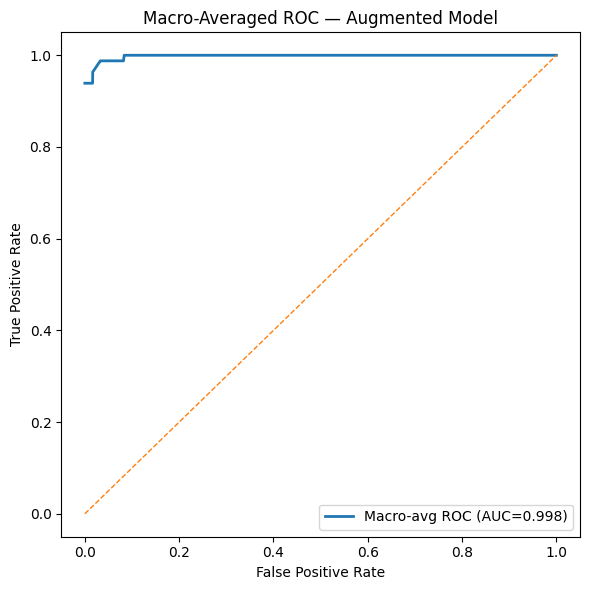

In [17]:
# %% [markdown]
# 📊 Fig 5 — Macro-averaged ROC curve (Augmented model; One-vs-Rest)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels for OvR ROC
classes = np.unique(y_test2)
y_test_bin = label_binarize(y_test2, classes=classes)

# decision_function gives continuous scores (better than predict_proba for LR with OvR here)
try:
    y_score = np.vstack([est.decision_function(X_test2) for est in aug_clf.estimators_]).T
    # y_score shape: (n_samples, n_classes) — ensure class order matches 'classes'
    # align if necessary (estimators_ order typically follows classes_, but we ensure mapping)
    # Build a mapping from class to column index in y_score
    class_order = aug_clf.classes_
    col_index = [np.where(class_order == c)[0][0] for c in classes]
    y_score = y_score[:, col_index]
except Exception as e:
    # fall back to predict_proba if available
    y_score = np.vstack([est.predict_proba(X_test2)[:, 1] for est in aug_clf.estimators_]).T
    class_order = aug_clf.classes_
    col_index = [np.where(class_order == c)[0][0] for c in classes]
    y_score = y_score[:, col_index]

# compute ROC per class then macro-average
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# macro-average (interpolate)
all_fpr = np.unique(np.concatenate([fpr[i] for i in fpr]))
mean_tpr = np.zeros_like(all_fpr)
for i in fpr:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(fpr)
macro_auc = auc(all_fpr, mean_tpr)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(all_fpr, mean_tpr, lw=2, label=f"Macro-avg ROC (AUC={macro_auc:.3f})")
ax.plot([0,1], [0,1], lw=1, linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Macro-Averaged ROC — Augmented Model")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()
